In [55]:
%cd ../src
%ls

[Errno 2] No such file or directory: '../src'
/home/roland/Desktop/Stage_4A/my_diffusion
cuda-keyring_1.0-1_all.deb  parameters2.npy  second_order_version1.ipynb
Diffusion_Notebooks/        parameters3.npy  second_VE_model.ipynb
parameters1.npy             parameters.npy   third_VE_model.ipynb


In [56]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random
import flax
from flax import linen as nn
import optax

import time

import os
import pickle

import matplotlib.pyplot as plt

from torch.utils import data
from torch.utils.data import Dataset

print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

the device used is [CpuDevice(id=0)] cpu
1


# Dataloader and metaparameters

In [57]:
seed = 0
key = random.PRNGKey(seed)
rng = key
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 1000

dimension = 2
T_max = 1.0

num_training_iterations = 100_000
ema_rate = 0.99

In [58]:
def generateBatchPoints(key, distribution = 'plus_sign', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )

    return(positions[...,None])

class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])
    
    

In [59]:
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

class NumpyLoader(data.DataLoader):
    def __init__(self, dataset, batch_size=1,
                  shuffle=False, sampler=None,
                  batch_sampler=None, num_workers=0,
                  pin_memory=False, drop_last=False,
                  timeout=0, worker_init_fn=None):
        super(self.__class__, self).__init__(dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            batch_sampler=batch_sampler,
            num_workers=num_workers,
            collate_fn=numpy_collate,
            pin_memory=pin_memory,
            drop_last=drop_last,
            timeout=timeout,
            worker_init_fn=worker_init_fn)

In [60]:
rng , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

## useful functions

In [61]:
beta = 1.
M = 1.
gamma = 0.1
Gamma = 2*M**0.5
BETA = lambda t : t*beta
Sigma_xx_0 = 0.
Sigma_vv_0 = gamma*M
Sigma_xx = lambda t : Sigma_xx_0 + jnp.exp(4*BETA(t)/Gamma) - 1 + 4*BETA(t)/Gamma*(Sigma_xx_0 - 1) + 4*(BETA(t)/Gamma)**2*(Sigma_xx_0 - 2) + 16*BETA(t)**2/Gamma**4*Sigma_vv_0
Sigma_xv = lambda t : -BETA(t)*Sigma_xx_0 + 4*BETA(t)/Gamma**2*Sigma_vv_0 - 2*BETA(t)**2/Gamma*(Sigma_xx_0 - 2) - 8*BETA(t)**2/Gamma**3*Sigma_vv_0
Sigma_vv = lambda t : Gamma**2/4*(jnp.exp(4*BETA(t)/Gamma) - 1) + BETA(t)*Gamma + Sigma_vv_0*(1 + 4*(BETA(t)/Gamma)**2 - 4*BETA(t)/Gamma) + BETA(t)**2*(Sigma_xx_0 - 2)

l_HSM = lambda t : jnp.sqrt( Sigma_xx(t)/(Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2) )

L_Cholesky = lambda t : jnp.array([ [jnp.sqrt(Sigma_xx(t)) , jnp.zeros( t.shape ) ] , [ Sigma_xv(t)/jnp.sqrt(Sigma_xx(t)) , jnp.sqrt( (Sigma_xx(t)*Sigma_vv(t) - Sigma_xv(t)**2)/Sigma_xx(t) ) ]]).transpose((2,0,1))

# mu for DSM
# def mu(t,x_0,v_0) :
#     return jnp.concatenate([ 2*BETA(t)/Gamma*x_0 + 4*BETA(t)/Gamma**2*v_0 + x_0 , -BETA(t)*x_0 - 2*BETA(t)/Gamma*v_0 + v_0 ], axis = -1 )*jnp.exp(-2*BETA(t)/Gamma)

# mu for HSM (v_0 = 0)
def mu_HSM(t_batch,x_0_batch) :
    batch_size = x_0_batch.shape[0]
    x_0 = x_0_batch
    t = t_batch.flatten()

    # shapes give (2, batch) (batch, dim,1) (batch)  -> (batch, 2, dim) 
    return jnp.array([ 2*BETA(t)/Gamma + 1 , -BETA(t) ]).T.reshape((batch_size,2,1))*x_0.reshape((batch_size,1,dimension))*jnp.exp(-2*BETA(t)/Gamma).reshape((batch_size,1,1))


In [62]:
# test 
batch = jnp.ones((batch_size,2,1))
t_batch = jnp.ones((batch_size,))

print(mu_HSM(t_batch, batch).shape)

print(L_Cholesky(t_batch).shape)

(512, 2, 2)
(512, 2, 2)


In [63]:
L_Cholesky(jnp.array([10]))

Array([[[2.202646e+04, 0.000000e+00],
        [8.671389e-03, 2.202646e+04]]], dtype=float32)

In [64]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :
    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))
    ###

    return(embedding)


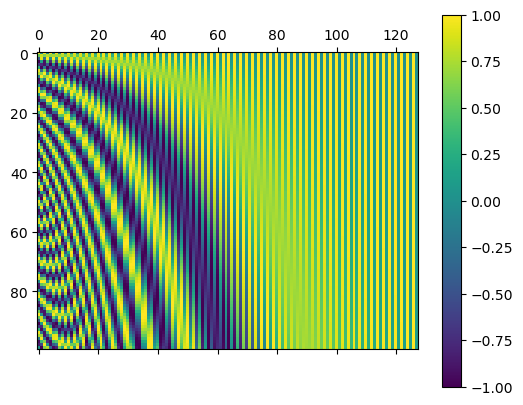

In [65]:
# test 
embedded = PositionalEncoding(jnp.arange(0,100))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [66]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x


In [67]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

def generateParameters(key):

    key, key1, key2, key3, key4 = random.split(key,5)

    # useless to put batch_size instead of '1'
    typical_batch = jnp.empty((batch_size, 2,1))
    typical_time_batch = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    typical_embedded_batch = jnp.empty((batch_size, 3*intermediate_features_embedding))
    
    params_times = batch_MLP_embedding_layers.init(key1, typical_time_batch)
    params_positions = batch_MLP_embedding_layers.init(key2, typical_batch)
    params_velocities =  batch_MLP_embedding_layers.init(key3, typical_batch)
    params_global = batch_MLP_final_layers.init(key4, typical_embedded_batch)
    

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_velocities' : params_velocities,
                'params_global' : params_global }
    
    return(key,parameters)

In [68]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

@jax.jit
def alpha_model(parameters,batch_positions, batch_velocities, time_indices) :

    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,1)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times = parameters['params_times']
    params_positions = parameters['params_positions']
    params_velocities = parameters['params_velocities']
    params_global = parameters['params_global']

    time_embedding = batch_MLP_embedding_layers.apply( params_times, time_embedding)
    position_embedding = batch_MLP_embedding_layers.apply( params_positions, batch_positions)
    velocity_embedding = batch_MLP_embedding_layers.apply( params_velocities, batch_velocities)
    
    global_embedding = jnp.concatenate( (time_embedding, position_embedding, velocity_embedding) , axis = 1)

    result = batch_MLP_final_layers.apply( params_global, global_embedding )[:,:,None]

    return(result)

In [69]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
batch_velocities = random.normal(key, (batch_size,2,1) )
result = alpha_model(parameters, batch, batch_velocities, times )
print(result.shape)

(512, 2, 1)


In [70]:
def timeIndeces2RealTime(time_indices ) :
    return( time_indices *1.0/num_timesteps)

@jax.jit
def batch_loss(parameters,batch, key) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_vitesses', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    """
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 1, maxval= num_timesteps)
    real_time_batch = timeIndeces2RealTime(time_indices )

    epsilon = random.normal(key3, shape = (batch_size,dimension, 2)) 

    batch_global = mu_HSM(real_time_batch, batch) + (L_Cholesky(real_time_batch)[:,None,:,:]@epsilon[...,None])[...,0].transpose( (0,2,1) ) # shape (batch_size, 2,dim)
    batch_positions = batch_global[:,0,:]
    batch_velocities = batch_global[:,1,:]

    loss = jnp.mean(( epsilon[:,:,1].squeeze() -  alpha_model(parameters,batch_positions, batch_velocities, time_indices).squeeze()  )**2 )
    return(loss)
    

In [71]:
# test 
real_time_batch = jnp.ones((batch_size,))

epsilon = random.normal(key, shape = (batch_size, 2, dimension))

batch_global = L_Cholesky(real_time_batch)@epsilon
print(batch_size)
print(L_Cholesky(real_time_batch).shape)
print(epsilon.shape)
print(batch_global.shape)

512
(512, 2, 2)
(512, 2, 2)
(512, 2, 2)


In [72]:
def train_or_retrieve_model(key, savingFileName = "second_order_parameters.npy") :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.001
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_iterations :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)

In [73]:
parameters = train_or_retrieve_model(key)

d (512, 2, 2, 1)
step : 0    -   loss : 0.94380295
step : 500    -   loss : 0.37694493
step : 1000    -   loss : 0.3338725
step : 1500    -   loss : 0.32163575
step : 2000    -   loss : 0.31703618
step : 2500    -   loss : 0.31289387
step : 3000    -   loss : 0.30940765
step : 3500    -   loss : 0.31027174
step : 4000    -   loss : 0.30703753
step : 4500    -   loss : 0.30634606
step : 5000    -   loss : 0.30608886
step : 5500    -   loss : 0.30530095
step : 6000    -   loss : 0.30536848
step : 6500    -   loss : 0.30370244
step : 7000    -   loss : 0.30349648
step : 7500    -   loss : 0.30433825
step : 8000    -   loss : 0.3027056
step : 8500    -   loss : 0.3018047
step : 9000    -   loss : 0.30096522
step : 9500    -   loss : 0.30074674
step : 10000    -   loss : 0.30079895
step : 10500    -   loss : 0.29980862
step : 11000    -   loss : 0.30153897
step : 11500    -   loss : 0.29812786
step : 12000    -   loss : 0.29862255
step : 12500    -   loss : 0.29941982
step : 13000    -   lo

In [74]:
def score(parameters,batch_positions, batch_velocities, time_indices) :
    real_time_batch = timeIndeces2RealTime(time_indices )
    return( -l_HSM(real_time_batch)[:,None,None]*alpha_model(parameters,batch_positions, batch_velocities, time_indices) )

In [75]:
# test 
batch_positions = jnp.zeros((batch_size,2,1))
batch_velocities = jnp.zeros((batch_size,2,1))
time_indices = jnp.ones((batch_size,))

sco = score(parameters,batch_positions, batch_velocities, time_indices)
print(sco.shape)

(512, 2, 1)


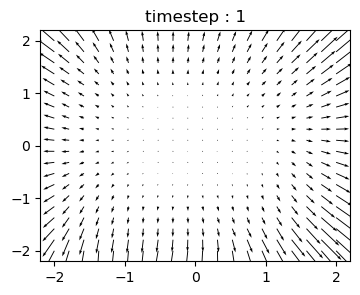

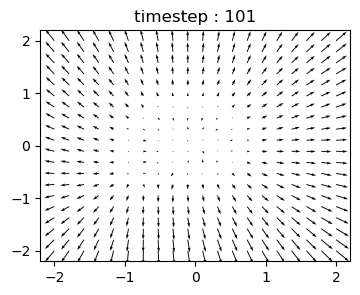

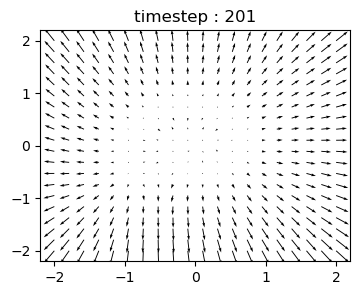

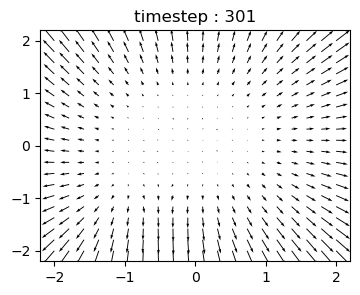

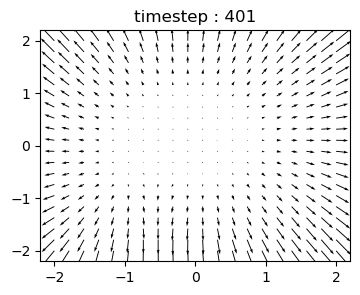

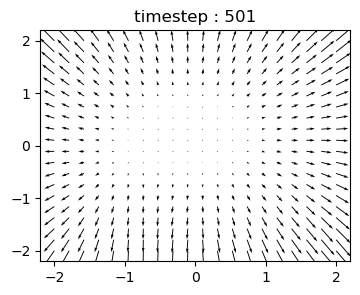

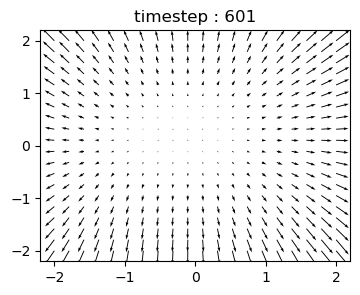

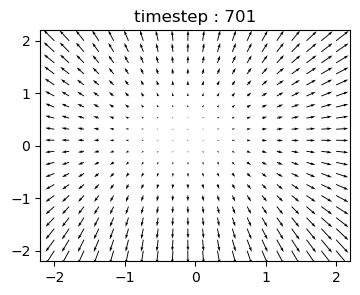

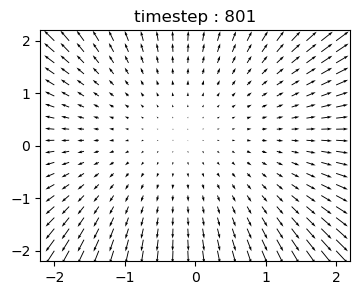

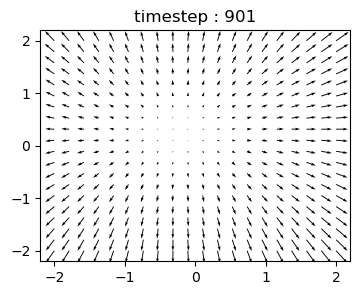

In [76]:
# test 
batch_velocities = jnp.zeros((batch_size, 2, 1))
# Batch_size must be superior to 400 for this test
for timestep in range(1,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-2,2,20),np.linspace(-2,2,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters, batch, batch_velocities, time_indices)[:400]
    u,v = scores[:,0,0], scores[:,1,0]
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [77]:
@jax.jit
def deterministic_predictor(batch, i, step_size, parameters ) :
    """ 
    - batch : shape (batch_size, 2, dim, 1)
    - i : integer
    - step_size : shape (batch_size,)
    - parameters : dict of parameters for score(...)
    """
    batch_positions = batch[:,0,...] 
    batch_velocities = batch[:,1,...] 
    batch_positions_updated = batch_positions -1.0/M*batch_velocities*beta*step_size[:,None,None] 
    batch_velocities_updated = batch_velocities + batch_positions*beta*step_size[:,None,None]  + 0 + \
                    2*Gamma*( score(parameters, batch_positions, batch_velocities, time_indices[i+1]) + batch_velocities/M )*beta*step_size[:,None,None]

    batch = jnp.concatenate( ( batch_positions_updated[:,None,:,:], batch_velocities_updated[:,None,:,:]), axis = 1)
    return(key, batch)

In [78]:
def timeSteps2stepSize(num_timesteps : int, batch_size : int):
    """ 
    - num_timesteps : int 
    - batch_size : int

    returns :
    - stepSize : shape (num_timesteps, batch_size) 
    """ 
    stepSize = jnp.ones((batch_size,num_timesteps)).T*1.0/num_timesteps
    return(stepSize)

In [79]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    batch = random.normal(key1, shape = (batch_size, 2, 2,1))*jnp.array([1,M]).reshape((1,-1,1,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        key, batch = deterministic_predictor( batch, i, stepSize[i], parameters )
        batch_positions = batch[:,0,:,:]
        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch_positions[:,0,0], batch_positions[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

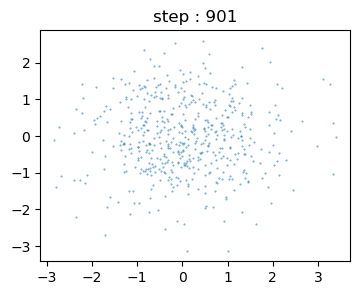

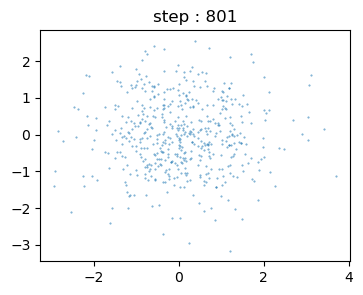

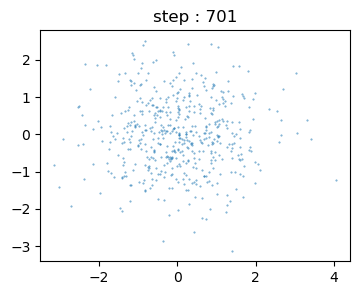

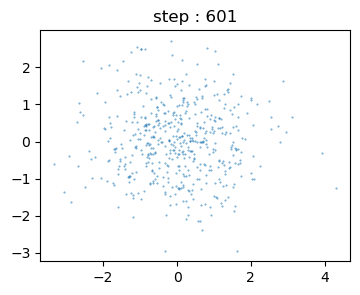

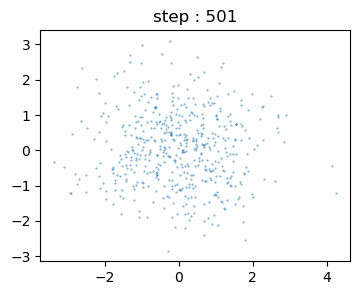

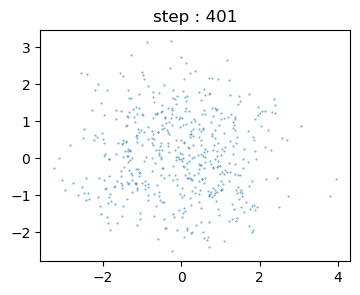

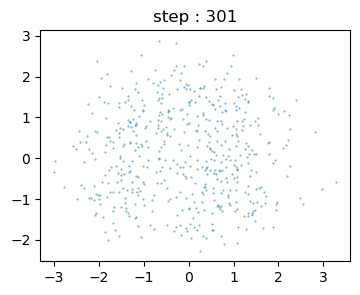

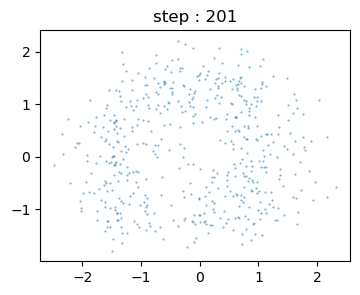

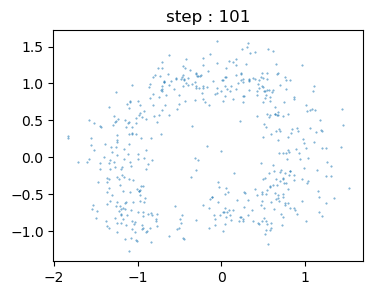

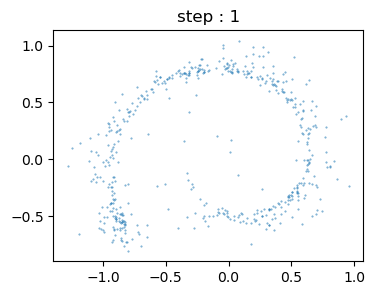

In [80]:
result = generate_deterministic_batch(key, parameters, time_indices = time_indices)